## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2,kernel_regularizer=l2(1e-4)):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=kernel_regularizer)(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
BATCH_SIZE = [128,256]
Dropout_EXP = 0.30
L2_EXP = [1e-8, 1e-12]
REGULARIZERS = {
    'l2 (0.01)': l2(1e-2),
    'l2 (0.0001)': l2(1e-4),
}

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for bachSize in BATCH_SIZE:
    for key in REGULARIZERS.keys():
        model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP, kernel_regularizer=REGULARIZERS[key])
        model.summary()
        optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=bachSize, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-batchsize-%s" % str(bachSize)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0728 20:13:10.435407 46880 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 20:13:12.655773 46880 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 20:13:13.212737 46880 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 20:13:14.269270 46880 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0728 20:13:16.032485 46880 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\optimizers.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0728 20:13:16.503608 46880 deprecation.py:323] From D:\python\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 35s 707us/step - loss: 5.1316 - acc: 0.3794 - val_loss: 3.9632 - val_acc: 0.1350
Epoch 2/50
50000/50000 [==============================] - 14s 278us/step - loss: 2.1039 - acc: 0.4027 - val_loss: 2.9953 - val_acc: 0.2041
Epoch 3/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.9241 - acc: 0.4071 - val_loss: 2.4716 - val_acc: 0.2722
Epoch 4/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.8440 - acc: 0.4223 - val_loss: 2.4094 - val_acc: 0.2808 los
Epoch 5/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.8061 - acc: 0.4300 - val_loss: 2.4246 - val_acc: 0.2813
Epoch 6/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.7806 - acc: 0.4394 - val_loss: 2.2950 - val_acc: 0.2763
Epoch 7/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.7600 - acc: 0.4458 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 315us/step - loss: 1.8310 - acc: 0.4022 - val_loss: 2.0954 - val_acc: 0.3292
Epoch 2/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.6320 - acc: 0.4673 - val_loss: 2.0350 - val_acc: 0.3474
Epoch 3/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.5530 - acc: 0.4909 - val_loss: 2.3675 - val_acc: 0.3094
Epoch 4/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.4835 - acc: 0.5172 - val_loss: 2.0115 - val_acc: 0.3610
Epoch 5/50
50000/50000 [==============================] - 14s 285us/step - loss: 1.4403 - acc: 0.5284 - val_loss: 2.4566 - val_acc: 0.2929
Epoch 6/50
50000/50000 [==============================] - 15s 308us/step - loss: 1.3811 - acc: 0.5480 - val_loss: 1.6392 - val_acc: 0.4614
Epoch 7/50
50000/50000 [==============================] - 18s 357us/step - loss: 1.3384 - acc: 0.5597 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 216us/step - loss: 6.6713 - acc: 0.3892 - val_loss: 3.9396 - val_acc: 0.1634
Epoch 2/50
50000/50000 [==============================] - 8s 166us/step - loss: 2.3866 - acc: 0.4222 - val_loss: 2.7368 - val_acc: 0.1972
Epoch 3/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.9744 - acc: 0.4329 - val_loss: 2.6824 - val_acc: 0.2026
Epoch 4/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.8430 - acc: 0.4420 - val_loss: 3.0389 - val_acc: 0.1796
Epoch 5/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.7753 - acc: 0.4520 - val_loss: 2.9672 - val_acc: 0.2246
Epoch 6/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.7449 - acc: 0.4565 - val_loss: 2.8797 - val_acc: 0.1955
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.7170 - acc: 0.4678 - val_loss: 2.4060 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.8393 - acc: 0.4042 - val_loss: 1.8861 - val_acc: 0.3622
Epoch 2/50
50000/50000 [==============================] - 11s 228us/step - loss: 1.6186 - acc: 0.4743 - val_loss: 1.9845 - val_acc: 0.3425
Epoch 3/50
50000/50000 [==============================] - 12s 231us/step - loss: 1.5290 - acc: 0.5020 - val_loss: 2.1754 - val_acc: 0.3073
Epoch 4/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.4618 - acc: 0.5292 - val_loss: 2.0126 - val_acc: 0.3533
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.4150 - acc: 0.5437 - val_loss: 2.3155 - val_acc: 0.3161
Epoch 6/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.3638 - acc: 0.5594 - val_loss: 1.8344 - val_acc: 0.4225
Epoch 7/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.3159 - acc: 0.5766 - val_loss: 2.

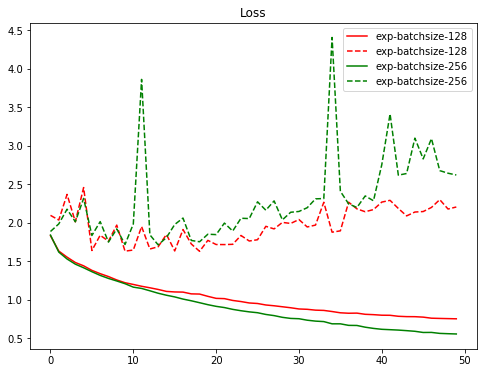

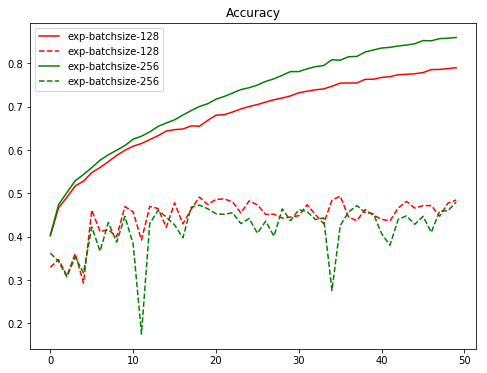

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()